Exercise 1

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

I start by downloading the data

In [2]:
#Data are from:
#http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()


Then, I choose some features, and I plot the the dependant variable with respect to them.

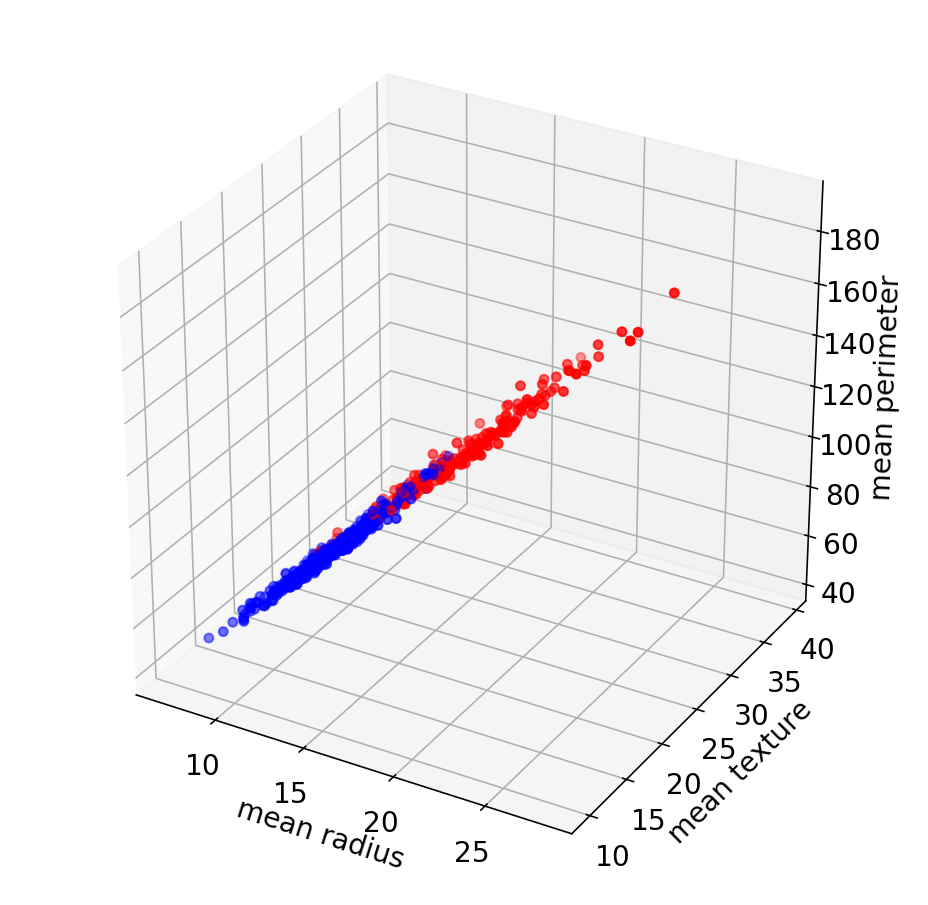

In [3]:
from mpl_toolkits.mplot3d import Axes3D

F1=data.data[:,0]
F2=data.data[:,1]
F3=data.data[:,2]
y=data.target

labels = ["b", "r"]
y = np.take(labels, (y < 1))

#In red, we have the malign cancers. In blue the begnin.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(F1,F2,F3, c=y)
ax.set_xlabel("mean radius")
ax.set_ylabel("mean texture")
ax.set_zlabel("mean perimeter")

In [4]:
from utils import draw_tree

from sklearn.tree import DecisionTreeClassifier
X = np.c_[F1, F2]


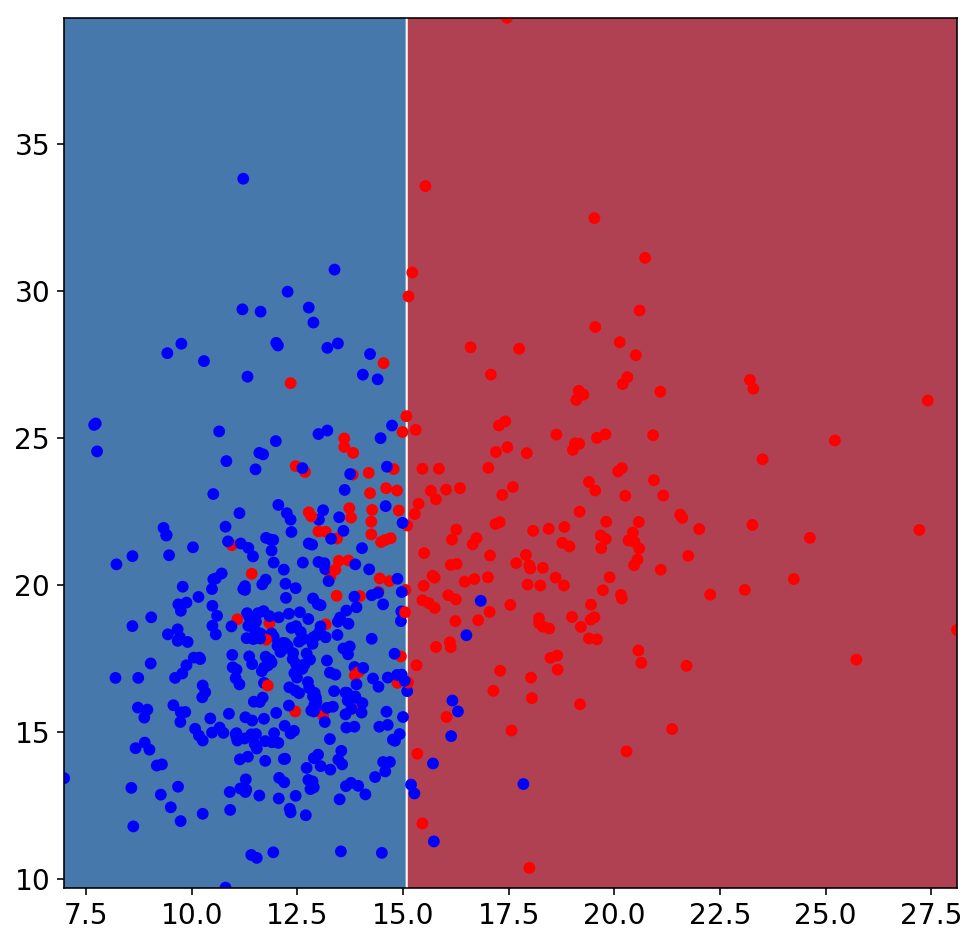

<function __main__.tree>

In [5]:
from ipywidgets import interact

from sklearn.tree import DecisionTreeClassifier

from utils import plot_surface


def tree(max_depth=1):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
    clf.fit(X, y)
    plot_surface(clf, X, y)
    
interact(tree, max_depth=(1, 25))

In [6]:
from sklearn.ensemble import RandomForestClassifier


X=data.data[:,:]
y=data.target

clf = RandomForestClassifier(bootstrap=True)
clf.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [7]:
for n, tree in enumerate(clf.estimators_):
    print("Prediction by tree %i" % n, tree.predict(X[:3,:]))
    
print("Prediction by forest", clf.predict(X[:3,:]))

Prediction by tree 0 [ 1.  0.  0.]
Prediction by tree 1 [ 0.  0.  0.]
Prediction by tree 2 [ 0.  0.  0.]
Prediction by tree 3 [ 1.  0.  0.]
Prediction by tree 4 [ 0.  0.  0.]
Prediction by tree 5 [ 0.  0.  0.]
Prediction by tree 6 [ 0.  0.  0.]
Prediction by tree 7 [ 0.  0.  0.]
Prediction by tree 8 [ 0.  0.  0.]
Prediction by tree 9 [ 0.  0.  0.]
Prediction by forest [0 0 0]


Since we have to find the correlation between the different trees, I have decided to use the correlation between the errors of prediction. I define a function in order to make my results more transparent.  

In [8]:
def cor_matrix_random_forest(X,y,m,max_f,bootstr):
    from sklearn.ensemble import RandomForestClassifier
    from scipy.stats import pearsonr
    clf = RandomForestClassifier(bootstrap=bootstr, max_features=max_f)
    clf.fit(X, y)
    A=[]
    for k in range(m):
        for l in range(m):
            pre_1 = clf.estimators_[k].predict(X)
            pre_2 = clf.estimators_[l].predict(X)
            rh_p= pearsonr((pre_1-y)**2, (pre_2-y)**2)[0]
            A.append(rh_p)
        
    A=np.reshape(A, (m, m)) 

    for k in range(m):
        for l in range(m):
            if k>=l:
                A[k,l]=0
    Average_cor=sum(sum(A))/(m*(m-1)/2)
    
    return A, Average_cor

In [9]:
X=data.data[:,:]
y=data.target
m=10
n=5
A_cor=[]
for k in range(n):
    A, Average_cor=cor_matrix_random_forest(X,y,m,'auto',True)
    A_cor.append( Average_cor)

The following plot consists of the correlation in a given forest. 

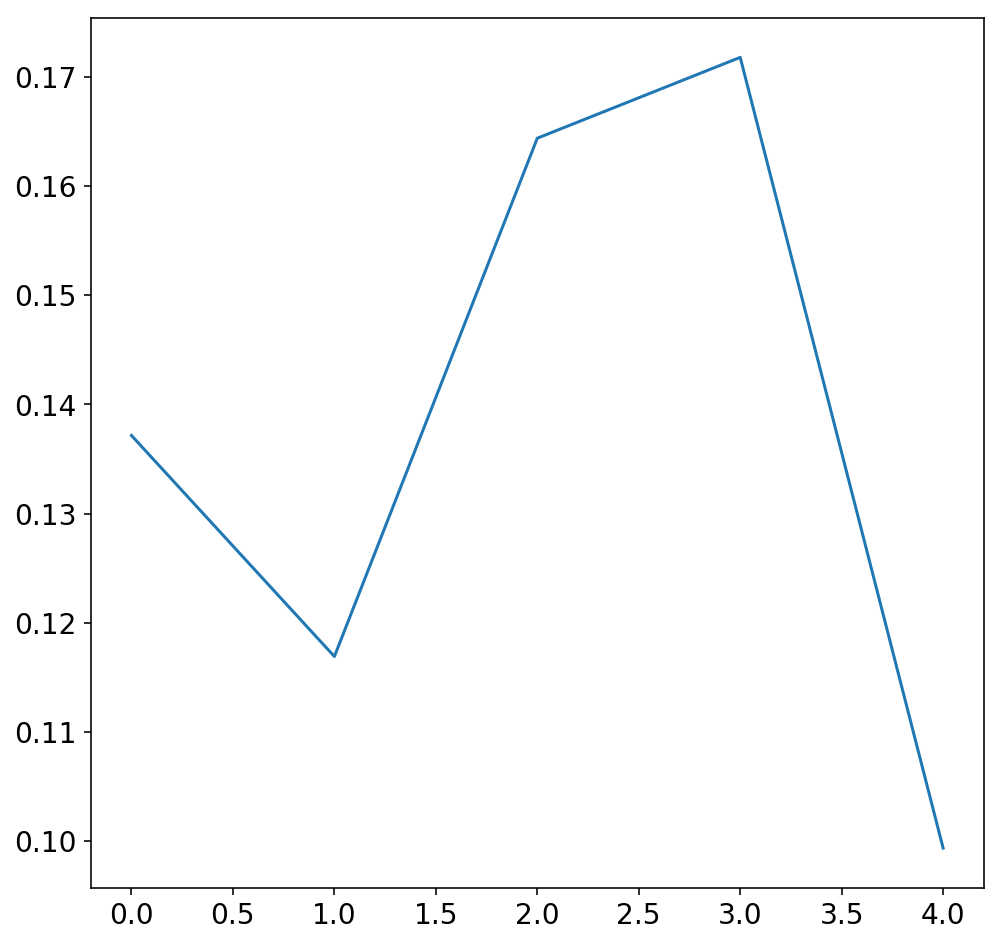

In [10]:
plt.plot(A_cor)

In the following lines, I replicate the experiment multiple times for a wide range of max_features. The graph suggests that the average correlation increases with max_feature.

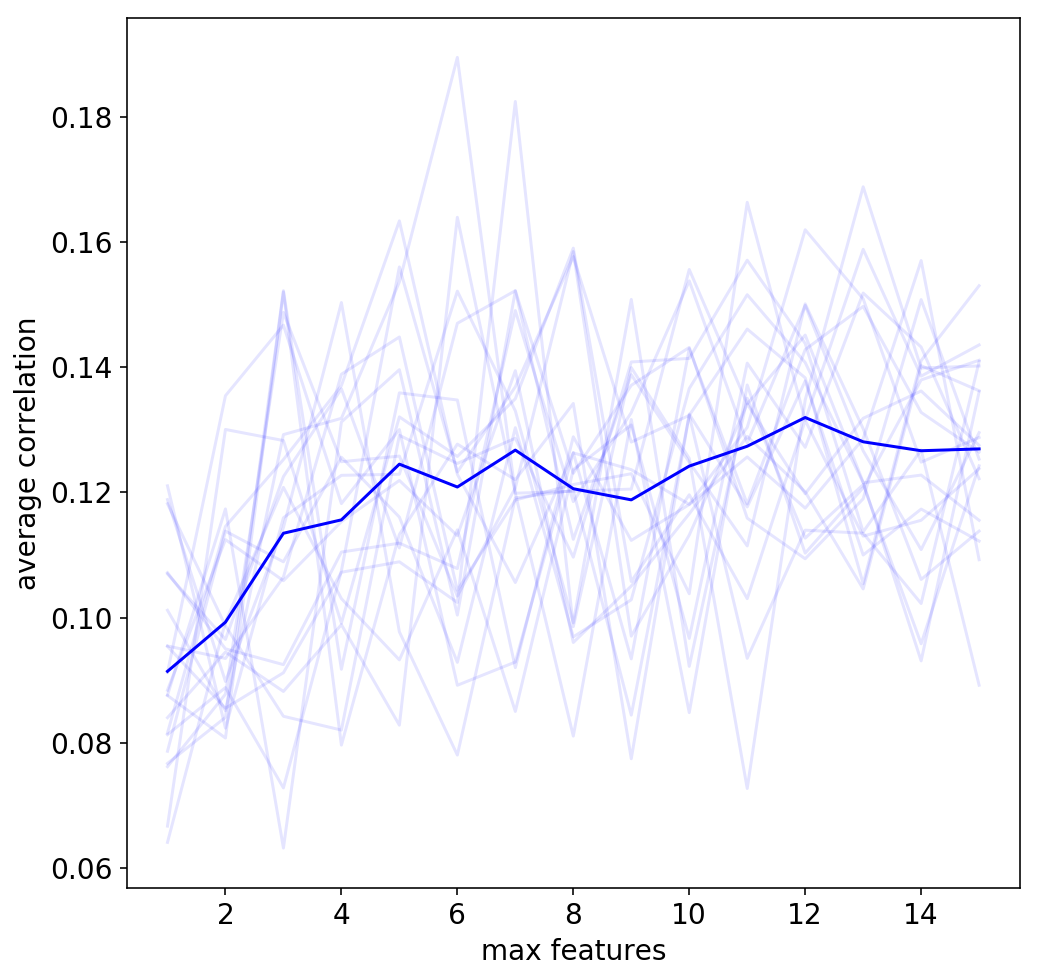

In [11]:
A_cor_1=[]
o=20
n=15
ks=[]
for k in range(n):
    ks.append(k+1)
    
for l in range(o):
    A_cor_2=[]
    for k in range(n):
        A, Average_cor=cor_matrix_random_forest(X,y,m,k+1,True)
        A_cor_2.append(Average_cor)
        A_cor_1.append(A_cor_2)
        
    plt.plot(ks, A_cor_2, '-b', alpha=0.1)
      
plt.plot(ks, np.array(A_cor_1).mean(axis=0), '-b')
plt.xlabel("max features")
plt.ylabel("average correlation")

Exercise 2

I have tried to replicate my function for other classifier, but with very little results unfortunately. 

In [12]:
def cor_matrix_random_forest_2(X,y,m,bootstr):
    from sklearn.ensemble import BaggingClassifier
    from scipy.stats import pearsonr
    clf = BaggingClassifier(bootstrap=bootstr)
    clf.fit(X, y)
    A=[]
    for k in range(m):
        for l in range(m):
            pre_1 = clf.estimators_[k].predict(X)
            pre_2 = clf.estimators_[l].predict(X)
            rh_p= pearsonr((pre_1-y)**2, (pre_2-y)**2)[0]
            A.append(rh_p)
        
    A=np.reshape(A, (m, m)) 

    for k in range(m):
        for l in range(m):
            if k>=l:
                A[k,l]=0
    Average_cor=sum(sum(A))/(m*(m-1)/2)
    
    return A, Average_cor

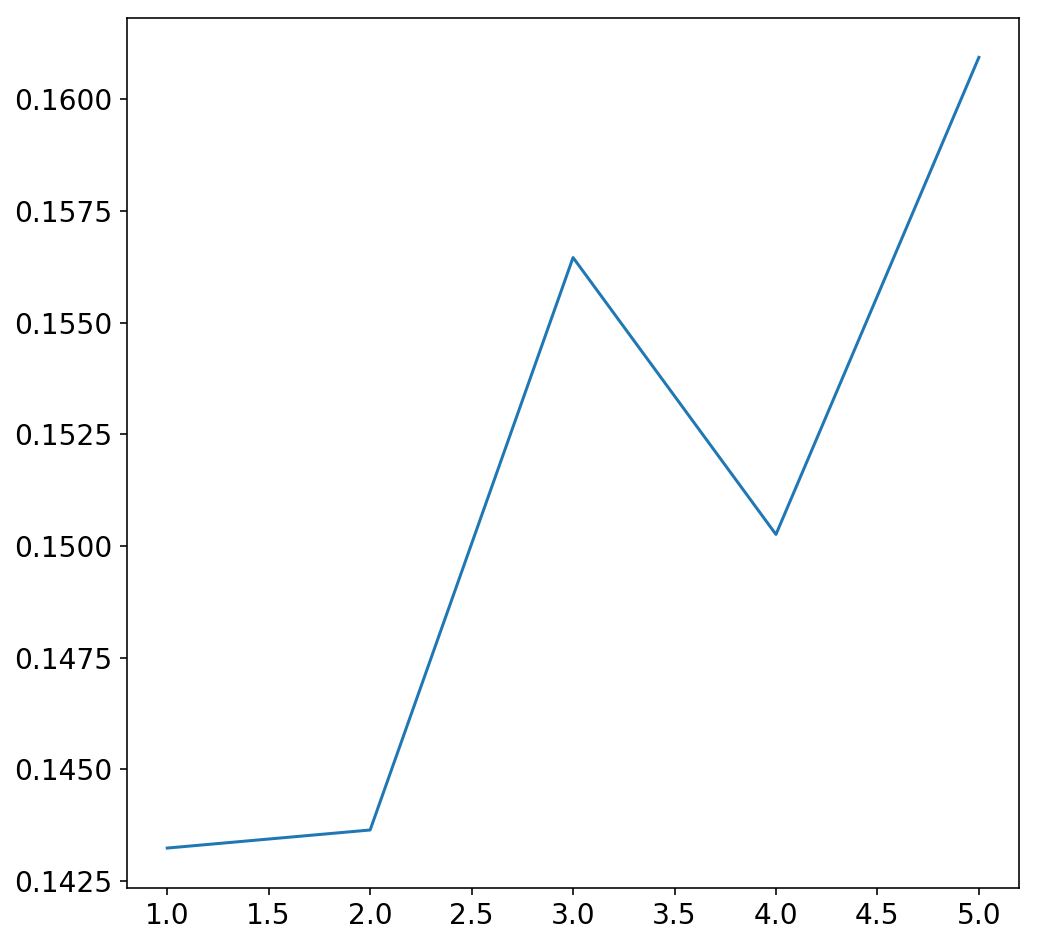

In [13]:
X=data.data[:,:]
y=data.target
m=10
n=5
ks=[]
for k in range(n):
    ks.append(k+1)
    
A_cor=[]  
for k in range(n):
    A, Average_cor=cor_matrix_random_forest_2(X,y,m,True)
    A_cor.append( Average_cor)
    
plt.plot(ks, A_cor)


Exercise 3

In [14]:
from sklearn.ensemble import GradientBoostingRegressor


def make_data(n_samples=800, n_features=8, noise=0.2, random_state=2):
    generator = check_random_state(random_state)

    X = generator.rand(n_samples, n_features)
    y = 10 * (X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 \
        + 10 * X[:, 3] + 10 * X[:, 4] + noise * generator.randn(n_samples)

    return X, y

X,y = make_data()

In [16]:
rgr = GradientBoostingRegressor(n_estimators=200, max_depth=2, learning_rate=0.1)
rgr.fit(X, y)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [18]:
rgr.feature_importances_

array([ 0.17387235,  0.13611995,  0.24843429,  0.20194025,  0.21372835,
        0.00538069,  0.01456878,  0.00595534])

<Container object of 8 artists>

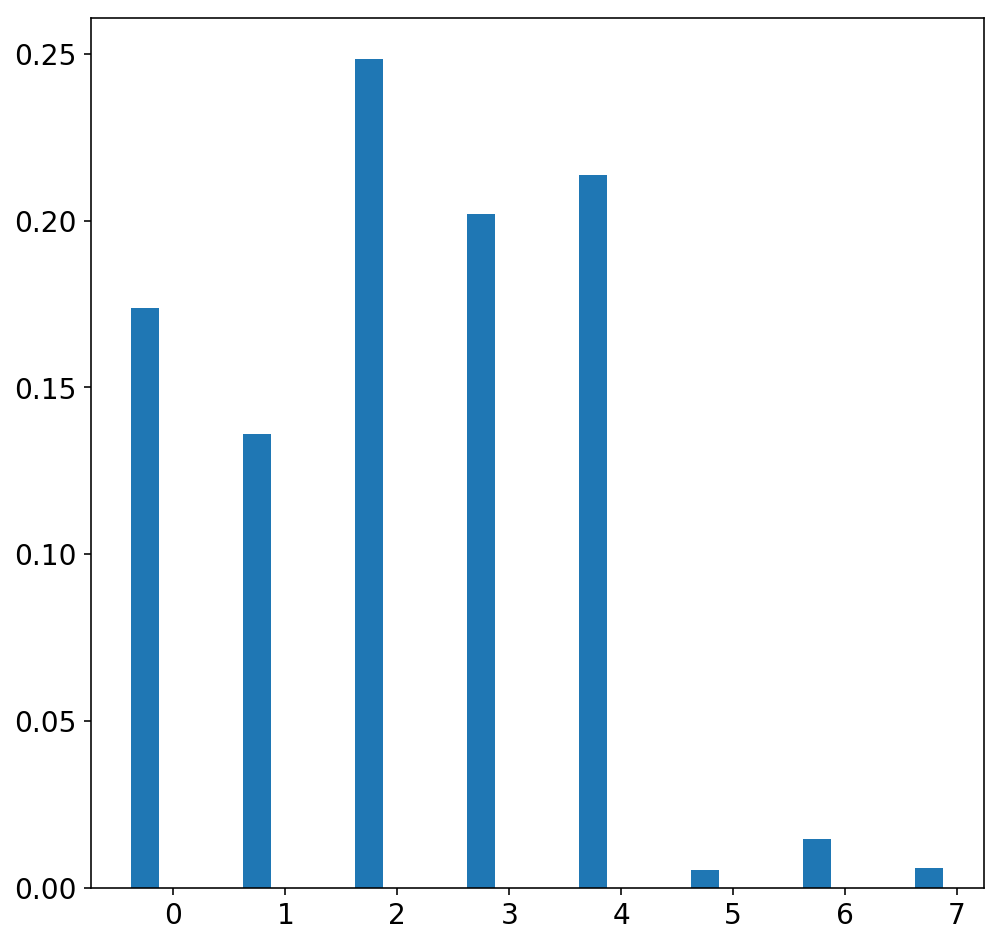

In [21]:
index = np.arange(len(rgr.feature_importances_))
bar_width = 0.25
plt.bar(index - bar_width, rgr.feature_importances_, bar_width, label='RGR')

-can you identify uninformative features?
Obviously, features 0-4 are highly informative while 5-7 are not. This result has to be expected from the definition of y (see make_data).


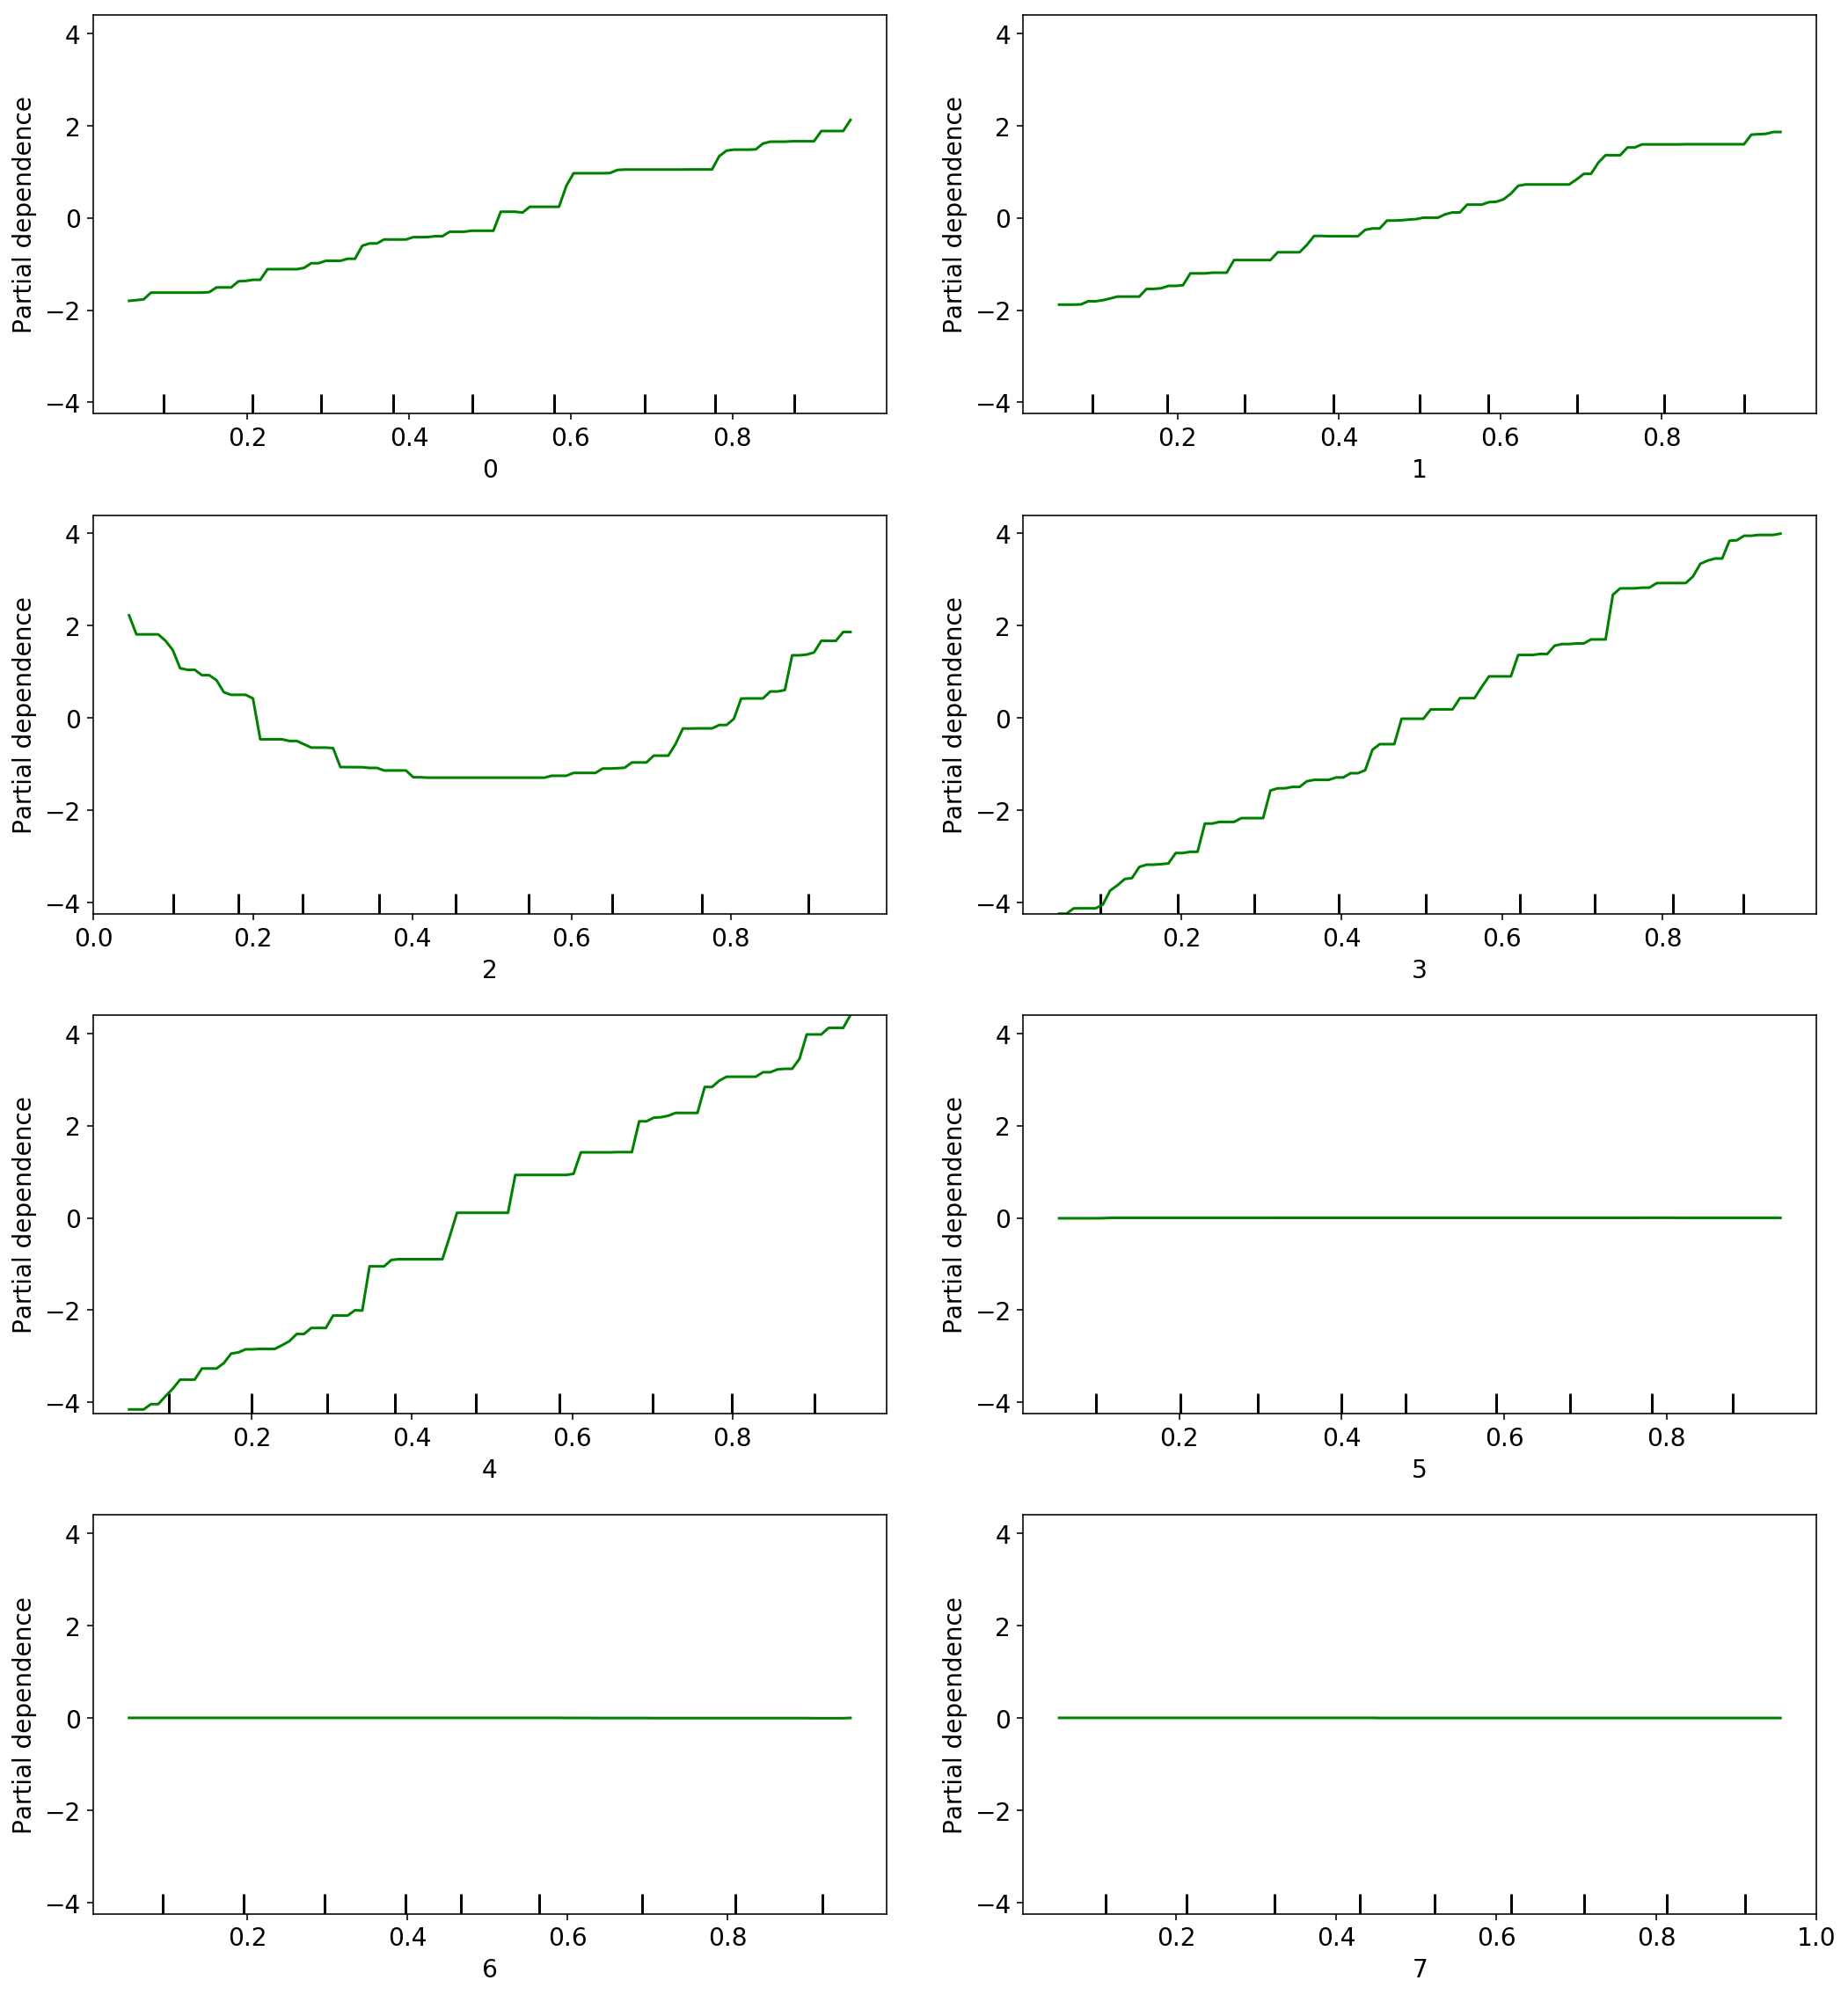

In [24]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(rgr, X, features=[0, 1, 2, 3, 4, 5, 6, 7 ],
                        figsize=(15,16), n_cols=2);
plt.tight_layout();

how do the interactions between the features show up in the partial dependence plots?
The interaction between the features follows closely the function make_data: Features 5-7 are uninformative. Feature 2 is centered around 0.5 and could be well approximated by a quadratic function. All the other features are linearly related to the dependant variable.

Exercise 4

In [79]:
from sklearn.datasets.california_housing import fetch_california_housing

cal_housing = fetch_california_housing()

In [80]:
y=cal_housing.target
X=cal_housing.data[:,:]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



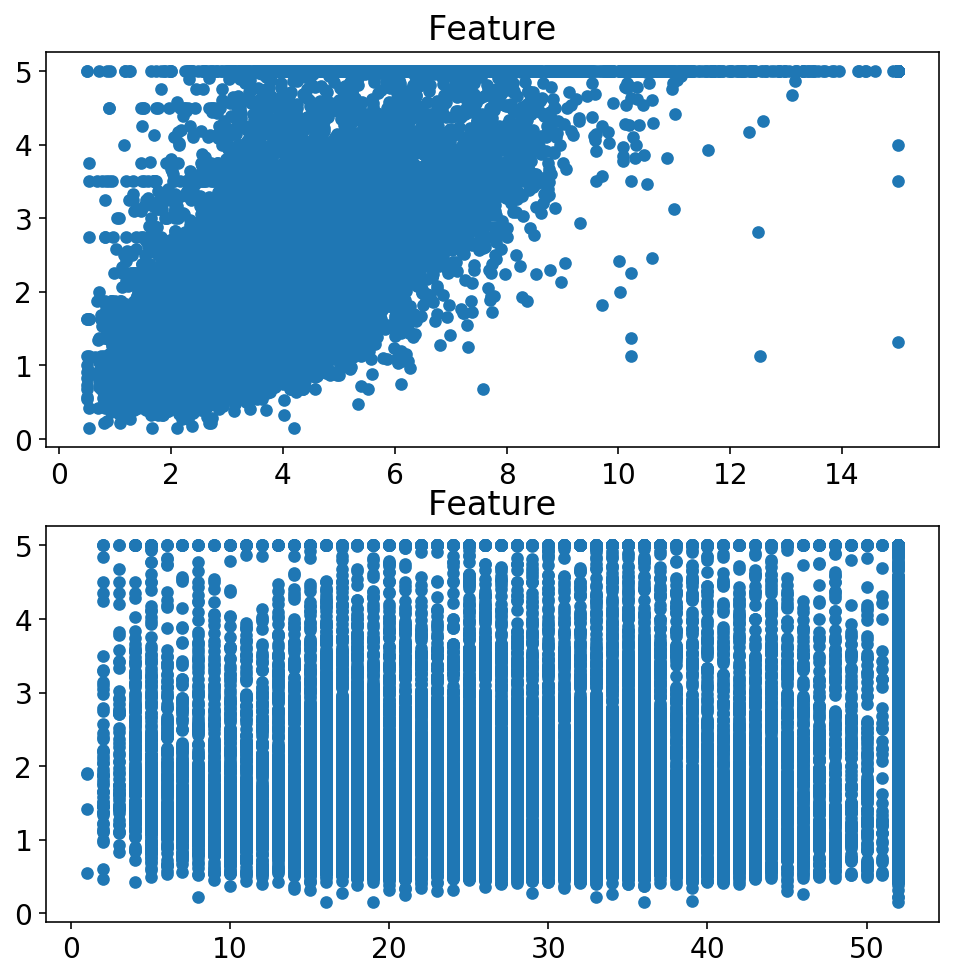

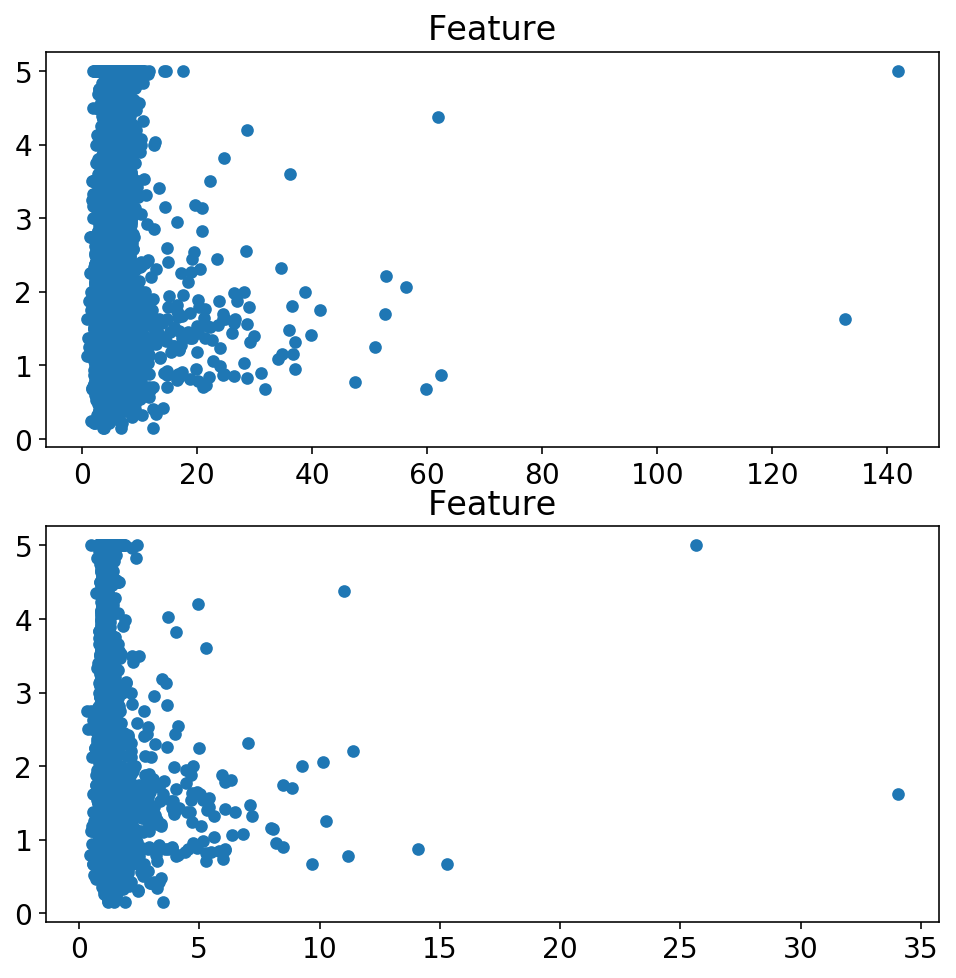

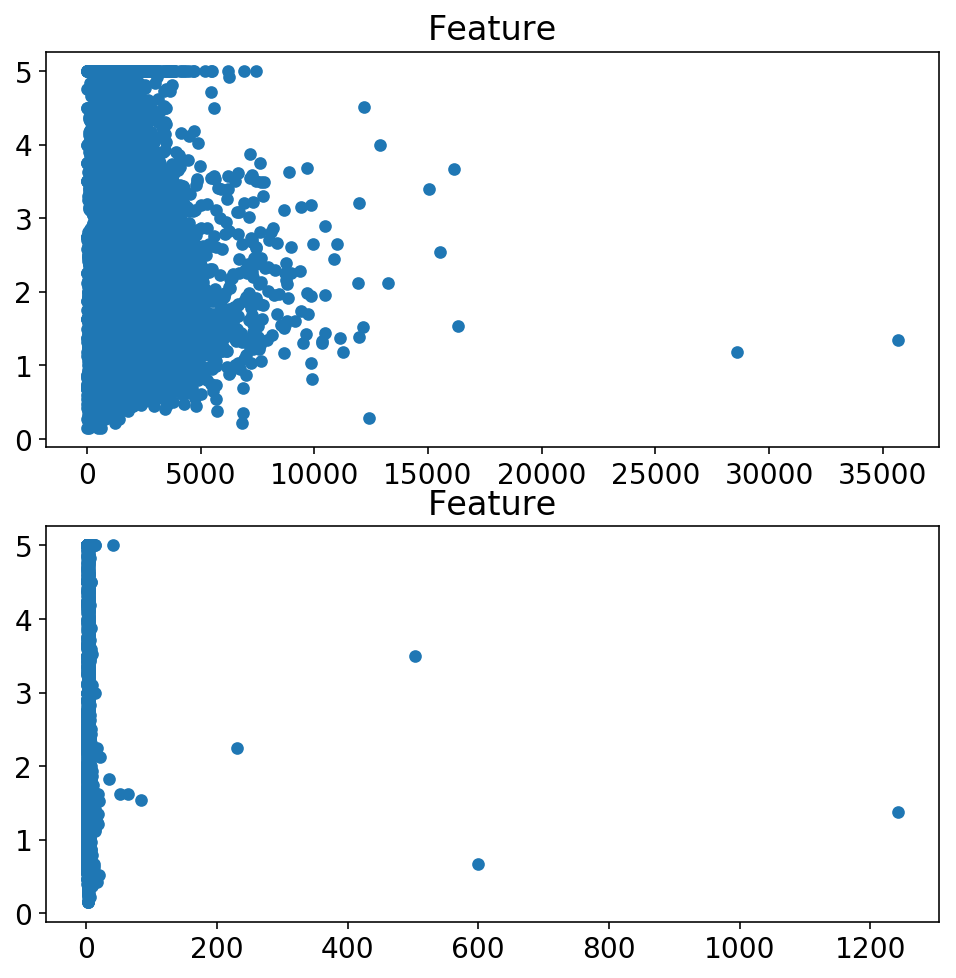

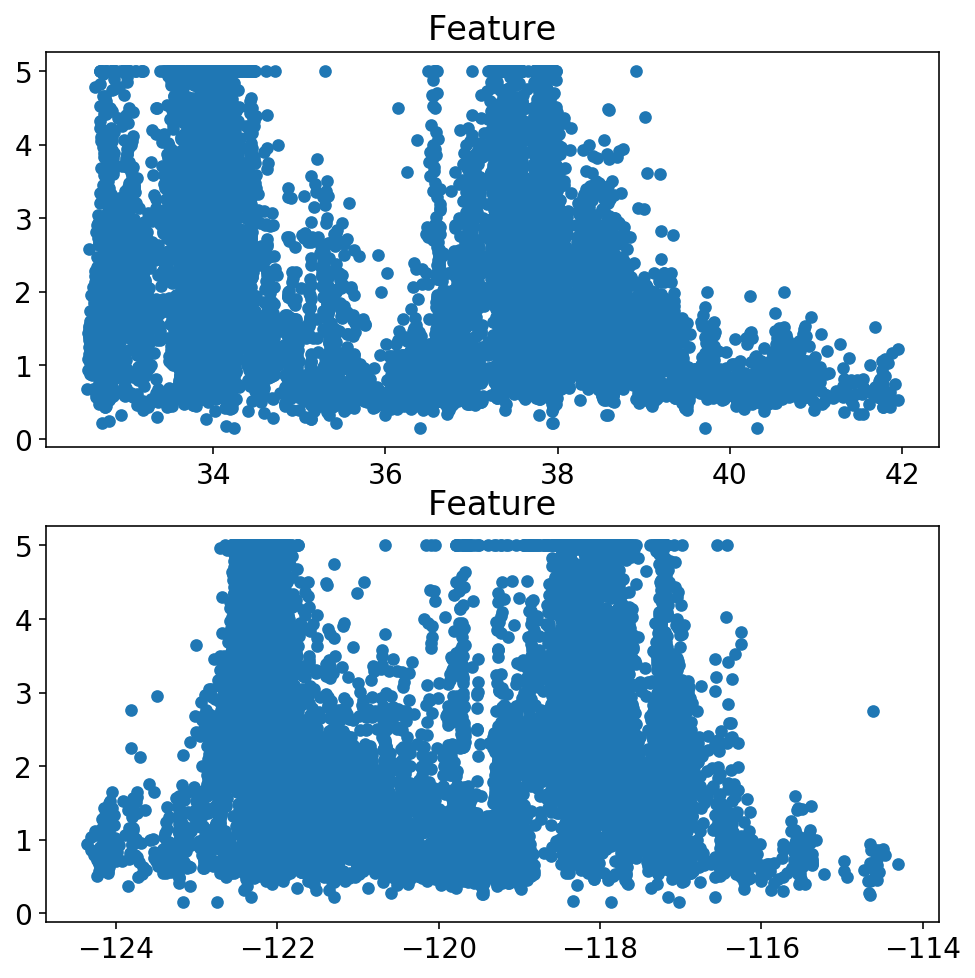

In [81]:
a,b = np.shape(X)
f, axarr = plt.subplots(2)
for k in range(0,2):
    axarr[k].scatter(X[:, k], y, lw=0, s=40)
    axarr[k].set_title('Feature')
    
g, axarr = plt.subplots(2)   
for k in range(2,4):
    axarr[k-2].scatter(X[:, k], y, lw=0, s=40)
    axarr[k-2].set_title('Feature')
    
h, axarr = plt.subplots(2)
for k in range(4,6):
    axarr[k-4].scatter(X[:, k], y, lw=0, s=40)
    axarr[k-4].set_title('Feature')
    
i, axarr = plt.subplots(2)   
for k in range(6,8):
    axarr[k-6].scatter(X[:, k], y, lw=0, s=40)
    axarr[k-6].set_title('Feature')

In [76]:
clf = GradientBoostingRegressor(n_estimators=1000, max_depth=2, learning_rate=.1)
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

<Container object of 8 artists>

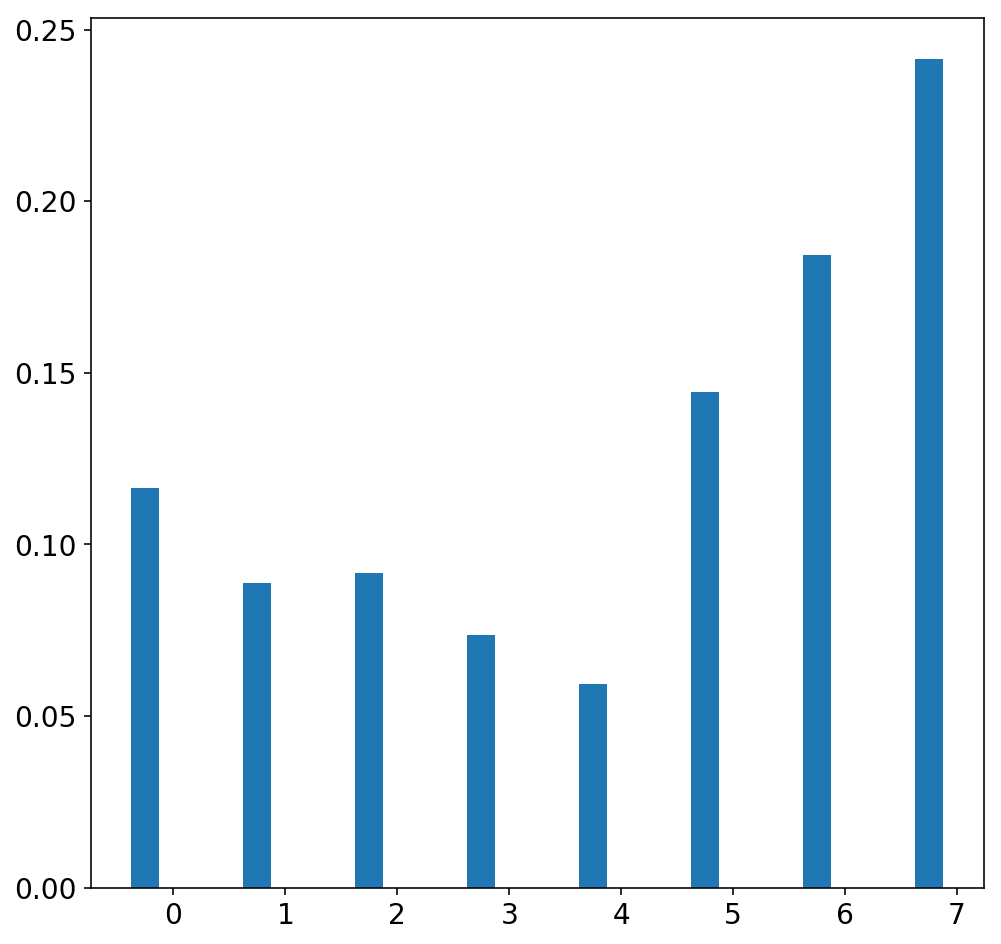

In [77]:
index = np.arange(b)
bar_width = 0.25
plt.bar(index - bar_width, clf.feature_importances_, bar_width, label='clf')

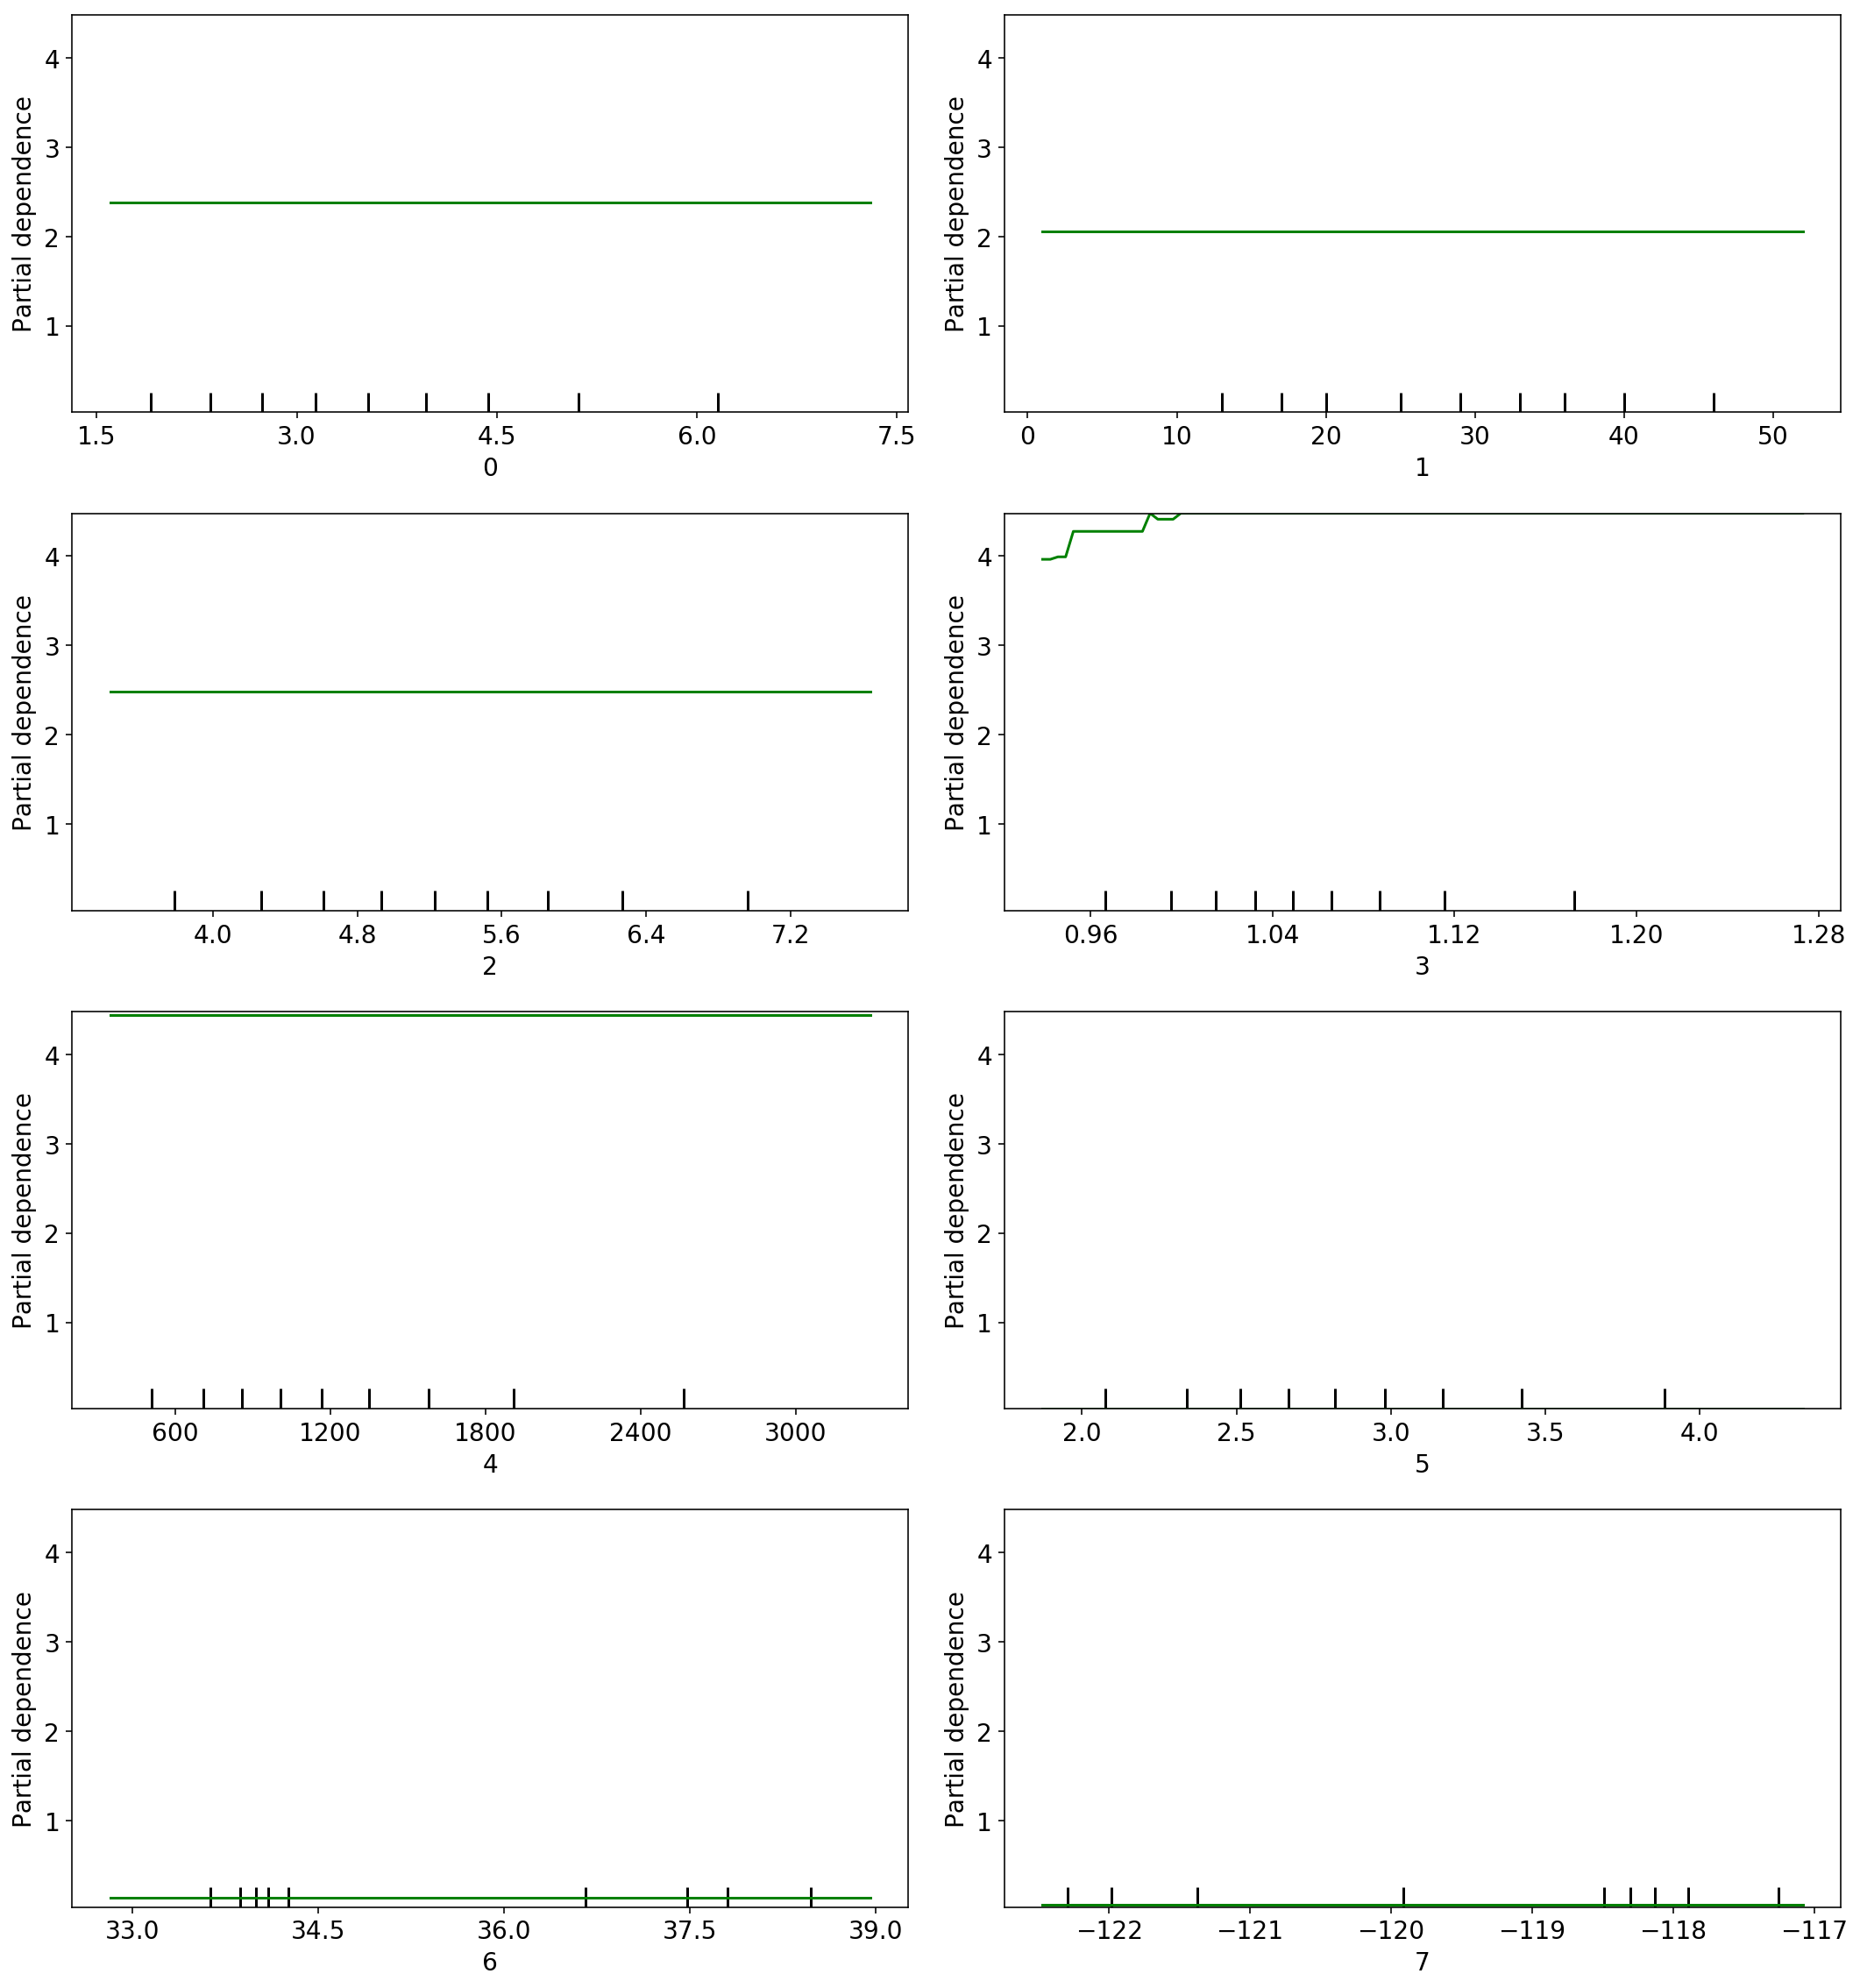

In [78]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plot_partial_dependence(rgr, X, features=[0, 1, 2, 3, 4, 5, 6, 7 ],
                        figsize=(15,16), n_cols=2);
plt.tight_layout();